# Structural Similarity
### Till 24.04.2021 (task in the end of the file)

During this seminar we will:
1. Consider some node similarity measures, particularly: *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance*
2. Take a look at *[Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* node reordering procedure
3. Calculate *Assortative mixing coefficient* for some **[Game Of Thrones](http://cdn.meme.am/instances/55597956.jpg)** network

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial as spt
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
%matplotlib inline

### Task 1 - Similarities Calculation

1. Calculate *Euclidean Distance*, *Correlation Coefficient* and *Cosine Distance* for some toy-network (Zachary again?) and for [Les Miserables](http://www-personal.umich.edu/~mejn/netdata/lesmis.zip) dataset
2. Visualize them

**HINT:**
For correlation coeficient you can use *np.corrcoef()*, for the distances you may implement them on your own or use *scipy.spatial.distance.pdist()*

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


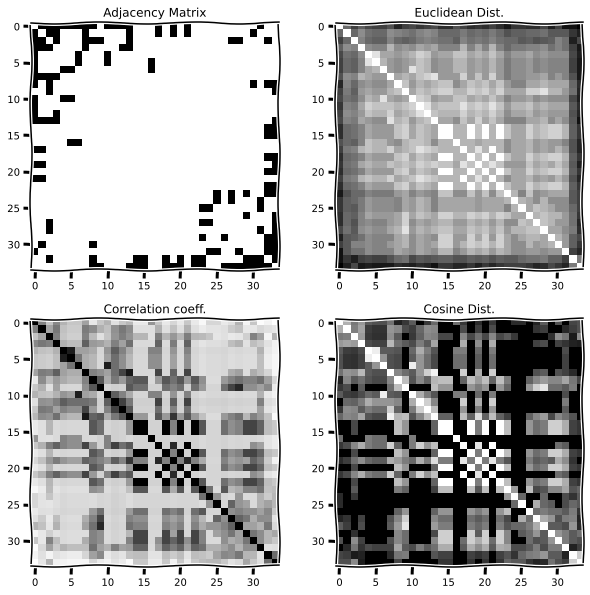

In [2]:
G = nx.karate_club_graph()
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
plotDist(A)   
    

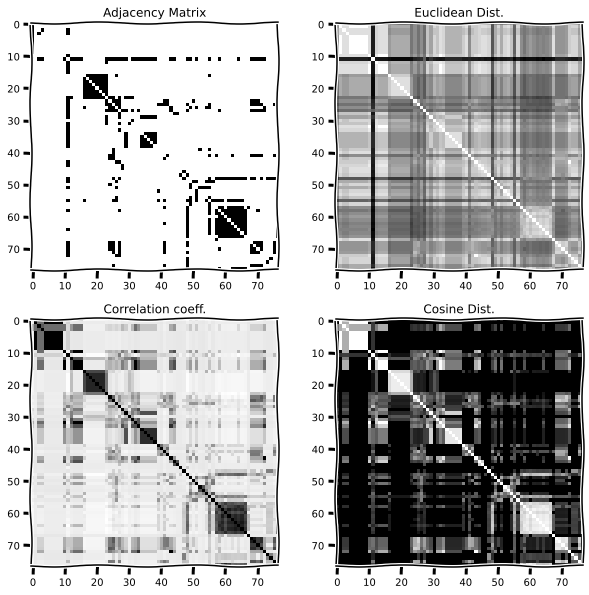

In [3]:
G = nx.read_gml('lesmis.gml')
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

plotDist(A)

### Task 2 - Node Reordering

Without special preprocess procedures graph adjacency matrix can look very noisy and hide network's structure (just look at the matrices above). Offcourse usually you don't know the structure itself (communities, groups of closelly connected nodes, etc.) unless it is given, however there are some procedures of node reordering that provides a better view of the network's adjacency matrix.

*[Reverse Cuthill-McKee](http://en.wikipedia.org/wiki/Cuthill%E2%80%93McKee_algorithm)* finds permutation of the nodes that minimizes the **bandwidth** of the matrix, which is calculated as:
$$ \theta = \max_{a_{ij} > 0}|i-j|$$
Unformally, this algorithm puts some *mass* on the diagonal of adjacency matrix.

Run this reordering with *nx.utils.reverse_cuthill_mckee_ordering(G)* and compare with the results above

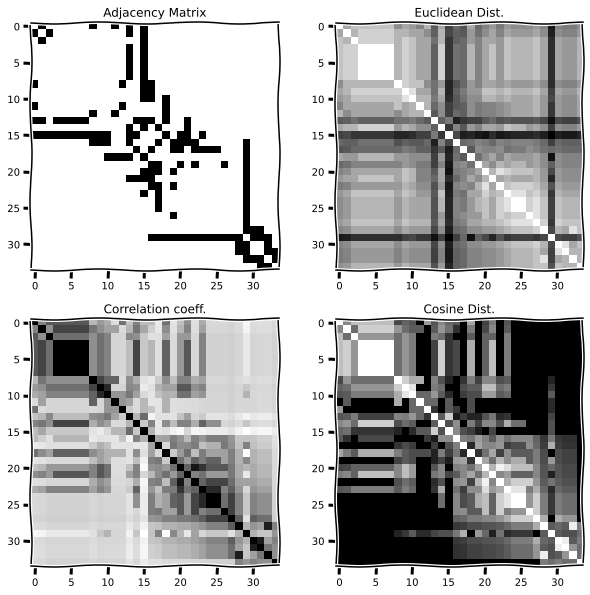

In [4]:
G = nx.karate_club_graph()

# run procedure
cm = nx.utils.reverse_cuthill_mckee_ordering(G)
# get permutation
l = [n for n in cm]
l

A = nx.to_numpy_matrix(G)
A = np.asarray(A)
# apply reordering
A = A[np.ix_(l,l)]

plotDist(A)



###  Task 3 - Assortative Mixing

For this task you should download some data, convert it to network and calculate assortative mixing coefficient. Particularly, download [*GOT data*](https://github.com/FutureUnleashed/OSS/tree/master/Neo4j/GOT_Tree): [*characters*](https://www.hse.ru/data/2016/03/15/1127718485/characters.csv) and [*events*](https://www.hse.ru/data/2016/03/15/1127718470/events.csv) datasets.

The first dataset provides information on characters of the Game Of Thrones universe. The second one -- describes some events that have occured with them during the story. We are interested in **killing** events since they can be considered as binary relations and consequently -- graphs. 
The attribute wrt which we are going to compute assortative mixing is called "Team".

We will explore datasets with *pandas* module. The list of usefull functions:
* read_csv()
* characters.head()
* dropna
* set_index('characterID')['Team'].to_dict()
* events[events['event'] == 'killed']

In [5]:
events = pd.read_csv('events.csv')
characters = pd.read_csv('characters.csv')

In [6]:
characters.head()

,characterID,Name,Team,isDead,isCaptured,isHurt,title,prefix
0,2,Addam Marbrand,Lannister,0,0,0,knight,Ser
1,1894,Adrack Humble,Greyjoy,0,0,0,NaN,NaN
2,7,Aegon Frey (Jinglebell),Frey (North),0,0,0,NaN,NaN
3,8,Aegon I Targaryen,Targaryen,1,0,0,King of the Seven Kingdoms,King
4,12,Aegon Targaryen,Targaryen,1,0,0,prince,Prince


In [7]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()

In [8]:
kill_events.head()

,characterID,event,withID
7,1808,killed,2068.0
9,1825,killed,1808.0
25,557,killed,456.0
289,1186,killed,1528.0
518,755,killed,629.0


In [9]:
G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)

In [10]:
ch_team = characters.set_index('characterID')['Team'].to_dict()
for k in list(ch_team):
    if k not in G.nodes():
        del ch_team[k]

In [11]:
nx.set_node_attributes(G, ch_team, 'Team')

In [12]:
nx.assortativity.attribute_assortativity_coefficient(G, 'Team')
as_dict = nx.assortativity.attribute_mixing_dict(G, 'Team')
as_dict

{'the Others': {'Night Watch': 5, 'Tyrell': 1, 'Wildling refugees': 1},
 'Night Watch': {'Night Watch': 4,
  'Wildlings (north of wall)': 5,
  'Tyrell': 1},
 'Tyrell': {'Renly': 3, 'Lannister': 1},
 'Wildling refugees': {},
 'Stark': {'Night Watch': 4,
  'Robert': 1,
  'Lannister': 4,
  'Stark': 1,
  'Frey (North)': 6,
  'Bolton (Lannister)': 1,
  'Brave Companions': 1,
  'Frey (Lannister)': 2,
  'Drogo': 1},
 'Lannister': {'Stark': 4,
  'Frey (Lannister)': 2,
  'Lannister': 1,
  'Robert': 2,
  'none': 1},
 'Frey (Lannister)': {},
 'Robert': {'Robert': 5,
  'Stark': 4,
  'Martell': 1,
  'Brave Companions': 2,
  'Second Sons': 1,
  'Essos': 1},
 'Martell': {'Robert': 1},
 'Brave Companions': {'none': 1, 'Lannister': 2},
 'Greyjoy': {'Wildlings (north of wall)': 1,
  'Stark': 4,
  'Greyjoy': 4,
  'Tyrell': 1},
 'Wildlings (north of wall)': {'Night Watch': 5,
  'Stark': 1,
  'Bolton (Lannister)': 1},
 'none': {'Stark': 2, 'Lannister': 3, 'none': 1, 'Night Watch': 2},
 'Drogo': {'Targaryen

# Home Task for Testing Assortativity

1. Experiment with GoT data, use different similarity metrics. Explain the results. You may choose another dataset on any TV channel serialization.

2. Find the example of temporal network, that increases assortativity at early stages and became higly disassortative later.
Explain this process.

3. Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the degree correlation coefficient (assortativity) in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.


### Task 1

In [13]:
events.event.value_counts()

mentioned              3966
killed                  147
changes allegiances     125
named                    53
captured                 36
freed                    20
attacked                 17
married                  16
presumed dead            11
gets                     10
alive                    10
engaged                   9
dies                      8
sentenced                 7
hurt                      6
sex                       5
healed                    3
captured - special        1
presumed captured         1
disappears                1
pregnant                  1
gives                     1
sent                      1
humilitated               1
heals                     1
turned down               1
other                     1
Name: event, dtype: int64

Let's experiment with killings, since we have id of the killer and id of the person, who was killed so we are able to build edges for our graph. So, basically we can see, that there are many people (nodes) in the series and not each one of them was killed or was a killer, we can obtain it from adjacency matrix, we see lot's of white color. We also can see that some people killed several times, as their distances are closer to some people (nodes), i.e. to people whom they killed.

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


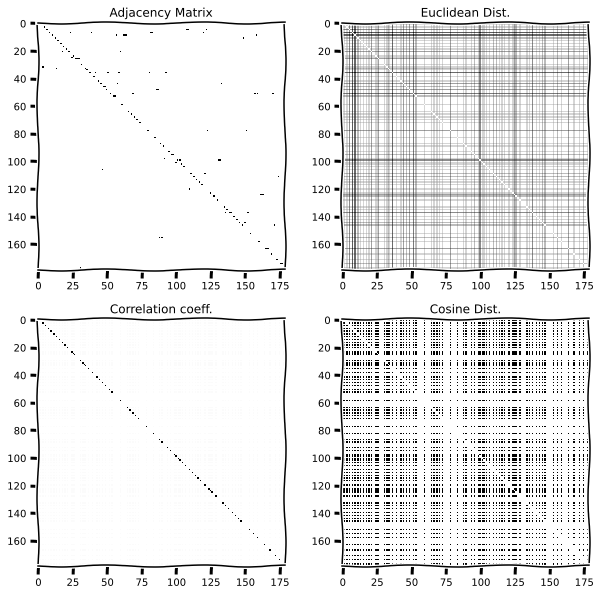

In [14]:
kill_events = events[events['event'] == 'killed']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()


G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)
    
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)
plotDist(A)

Let's try also marriage and sex graph. On the sex graph we can see, that probably there was a rape in the series (I don't know, didn't watch it), since person didn't have sex with somebody, but someone had with them. As for marriage, both persons got married, everything is ok. We can also see that some people married twice and firstly they married someone from close surroundings and then married person from far community.

/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/alexander/PythonProjects/MO/venb/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


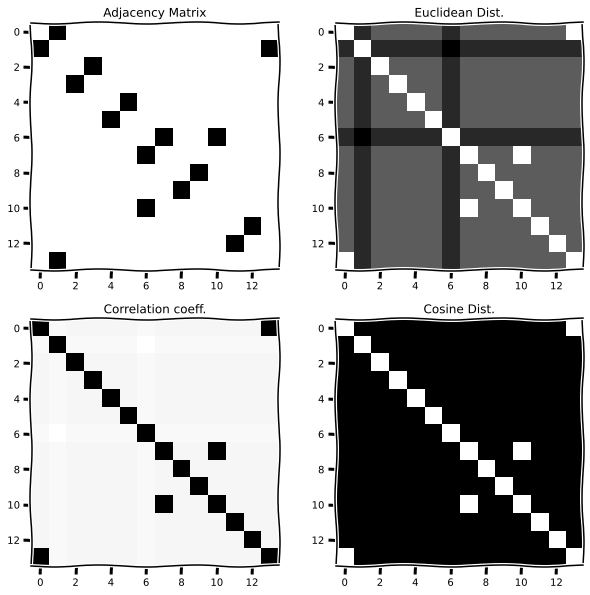

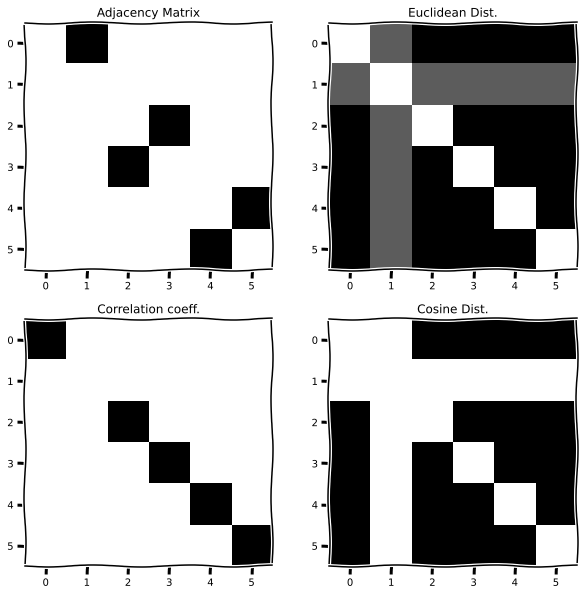

In [15]:
kill_events = events[events['event'] == 'married']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()


G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)
    
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)
plotDist(A)

kill_events = events[events['event'] == 'sex']
kill_events = pd.DataFrame(kill_events, index = None, columns=['characterID', 'event', 'withID'])
kill_events = kill_events.dropna()


G = nx.DiGraph()

for row, data in kill_events.iterrows():
    killer = data[2]
    killed = data[0]
    G.add_edge(killer, killed)
    
B = nx.to_numpy_matrix(G, dtype=int)
B = np.asarray(B)
plotDist(B)

### Task 2

In this task I will use temporal network of five coworkers from small company, that send messages to each other, but after some time their connections changed. There will be 3 time stamps, that is 3 years of work.

In [16]:
year1 = pd.read_csv("year1.csv")
year2 = pd.read_csv("year2.csv")
year3 = pd.read_csv("year3.csv")

In [17]:
year1

,1,2,3,4,5
0,1,1,1,0,0
1,1,1,0,0,1
2,1,1,1,1,1
3,1,1,0,0,0
4,1,1,1,1,1


In [18]:
Year1 = nx.convert_matrix.from_numpy_matrix(np.array(year1))
Year2 = nx.convert_matrix.from_numpy_matrix(np.array(year2))
Year3 = nx.convert_matrix.from_numpy_matrix(np.array(year3))

In [19]:
print(nx.degree_assortativity_coefficient(Year1))
print(nx.degree_assortativity_coefficient(Year2))
print(nx.degree_assortativity_coefficient(Year3))

-0.1999999999999945
-0.0645161290322576
-0.27071823204419987


As we see, firstly assortativity was increased, since some persons became more similar in types of connections with each other, probably, they send messages to same people and get answers back or send tasks to same amount of people, however, then team was restructured and they send messages to different people of even send less messages at all.

### Task 3

Take biological network. Let's prun the largest-degree nodes of a growing scale-free network has the effect of decreasing the degree correlation coefficient (assortativity) in a stable way, while keeping both the trait of a power-law degree distribution and the main properties of network's robustness. Explain the results. Propose a generative model for disassortative growing scale-free networks.

Use predownloaded bio-CE biological network:

In [92]:
FielName="bio-CE.edges"
Graphtype= nx.DiGraph()   # use net.Graph() for undirected graph

# How to read from a file. Note: if your egde weights are int, 
# change float to int.
G = nx.read_edgelist(
    FielName, 
    create_using=Graphtype,
    nodetype=int,
    data=(('weight',float),)
)

In [93]:
my_list = []
for i in range(200):
    my_list.append(nx.degree_assortativity_coefficient(G))
    node = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]
    G.remove_node(node)

So here we get result after prunning our biological network, as we see after getting rid of nodes degree assortativity doesn't really change that fast, after some time if of course changed a bit, but remined rather stable for a long time. Why is it so? The thing is a that the network is scale-free and nodes connected by a power law, so when we delete the highhest degree node, we don't change law of connections of other nodes.

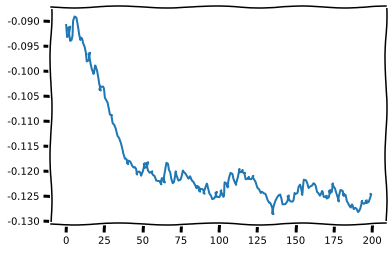

In [94]:
plt.plot(my_list)
plt.show()

For this task I took the model from the web, here C is a coefficient from 0 to 1, k - is a node. П - propability of being attached to the old node. This model considerers the importance of each of the neighbours of a target node in preferential attachment.

In [32]:
from IPython.display import HTML

HTML(
     """<iframe src="https://sun9-32.userapi.com/impg/ra4EKIDJx739i3Wmj9QBZcx7Cv9wUEzMT-ztKg/h9HTtn8yCJI.jpg?size=285x100&quality=96&sign=b3ab9d8fdecc66190fbb09d3f0e5b719&type=album"
     width="370" height="150"></iframe>"""
)